# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2022/11/10<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

**Code Example Explanations Prepared by Jasper Zhang for Health Data Working Group Workshop**

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [ ]:
import tensorflow as tf  # Import the TensorFlow library

# Import the 'keras' submodule from TensorFlow, which provides a high-level interface for building and training deep learning models
from tensorflow import keras

# Import the 'layers' submodule from TensorFlow Keras, which provides pre-built layers for constructing neural network architectures
from tensorflow.keras import layers

import numpy as np


## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  73.3M      0  0:00:10  0:00:10 --:--:-- 99.5M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.

In [ ]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [ ]:
import os  # Import the 'os' module to interact with the file system

num_skipped = 0  # Initialize a counter for skipped (corrupted) images

# Iterate through the "Cat" and "Dog" folders
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)  # Create the full path to the current folder

    # Iterate through each file in the current folder
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)  # Create the full path to the current file

        try:  # Open the file and check if it contains the JFIF signature (indicating a valid JPEG file)
            fobj = open(fpath, "rb")  # Open the file in binary mode for reading
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)  # Check if the JFIF signature is present in the first 10 bytes of the file
        finally:
            fobj.close()  # Close the file

        if not is_jfif:  # If the file is not a valid JPEG image
            num_skipped += 1  # Increment the counter for skipped images
            os.remove(fpath)  # Delete the corrupted image

print("Deleted %d images" % num_skipped)  # Print the total number of deleted (corrupted) images


Deleted 1590 images


## Generate a `Dataset`

In [ ]:
image_size = (180, 180)  # Set the target image size to 180x180 pixels
batch_size = 128  # Set the batch size for training and validation to 128 images



# Create TensorFlow ImageDataGenerator for training and validation datasets
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",  # Specify the "PetImages" directory as the source of images
    validation_split=0.2,  # Allocate 20% of the images for validation
    subset="both",  # Indicate that both training and validation datasets should be generated
    seed=2023,  # Set a random seed to ensure reproducibility of dataset splitting
    image_size=image_size,  # Resize all images to the specified target size (180x180)
    batch_size=batch_size,  # Set the batch size for both training and validation datasets to 128
)




Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


**Batch size** is a hyperparameter in machine learning and deep learning models that defines the number of samples (data points) to be processed together during a single pass (iteration) of training or inference. It plays a significant role in the optimization process, as well as computational efficiency.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
and label 0 is "cat".

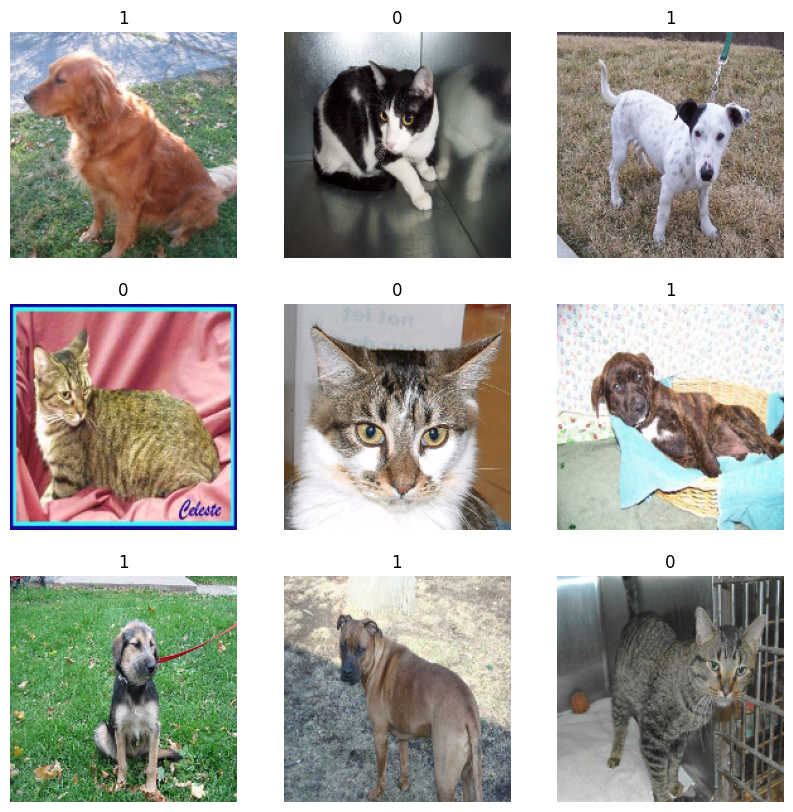

In [ ]:
import matplotlib.pyplot as plt  # Import the 'pyplot' submodule from the 'matplotlib' library for creating visualizations

plt.figure(figsize=(10, 10))  # Create a new figure with a custom size (10x10 inches)

# Iterate through the first batch of images and labels in the training dataset (train_ds)
for images, labels in train_ds.take(1):
    for i in range(9):  # Display the first nine images in the batch
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot in a 3x3 grid for the current image (i)
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the i-th image, converted from a tensor to a NumPy array of unsigned 8-bit integers
        plt.title(int(labels[i]))  # Set the title of the subplot to the label (class) of the i-th image
        plt.axis("off")  # Remove axis ticks and labels from the subplot

# The resulting plot will show a 3x3 grid of images from the first batch of the training dataset


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

This code snippet creates a Keras Sequential model for data augmentation, which will be applied to the training images. Data augmentation is a technique used to artificially increase the diversity and size of the training dataset by applying random transformations to the images.

In [ ]:
data_augmentation = keras.Sequential(  # Create a Keras Sequential model for data augmentation
    [
        layers.RandomFlip("horizontal"),  # Add a layer that performs random horizontal flipping of the images
        layers.RandomRotation(0.1),  # Add a layer that applies random rotations to the images within a range of ±10% (0.1 * 180 degrees)
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first image in the dataset:

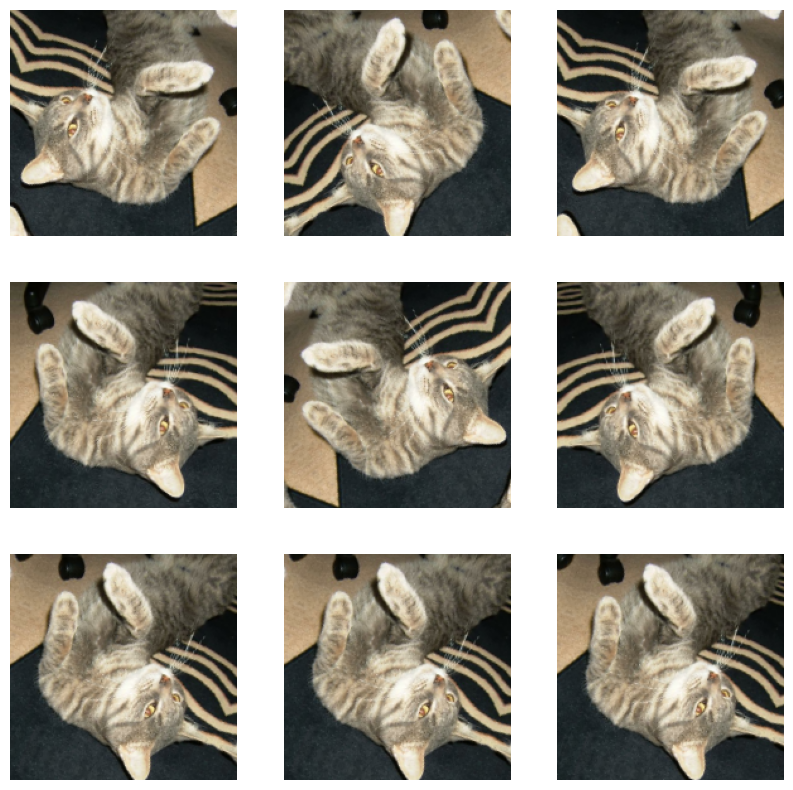

In [ ]:
plt.figure(figsize=(10, 10))  # Create a new figure with a custom size (10x10 inches)

# Iterate through the first batch of images in the training dataset (train_ds)
for images, _ in train_ds.take(2):
    for i in range(9):  # Display nine augmented images
        augmented_images = data_augmentation(images)  # Apply the data_augmentation model to the images
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot in a 3x3 grid for the current image (i)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))  # Display the first image from the augmented batch, converted from a tensor to a NumPy array of unsigned 8-bit integers
        plt.axis("off")  # Remove axis ticks and labels from the subplot

# The resulting plot will show a 3x3 grid of augmented images from the first batch of the training dataset


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

This code snippet applies the data_augmentation model to the training dataset and optimizes the performance of the dataset by prefetching samples in GPU memory.

In [ ]:
# Apply 'data_augmentation' to the training images using the 'map' function
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),  # Apply the data augmentation to each image, keeping the labels unchanged
    num_parallel_calls=tf.data.AUTOTUNE,  # Use TensorFlow's AUTOTUNE to automatically choose the optimal number of parallel calls for the mapping operation
)

# Prefetching samples in GPU memory helps maximize GPU utilization by pre-loading the data
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)  # Prefetch the training dataset using AUTOTUNE for optimal performance
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)  # Prefetch the validation dataset using AUTOTUNE for optimal performance


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

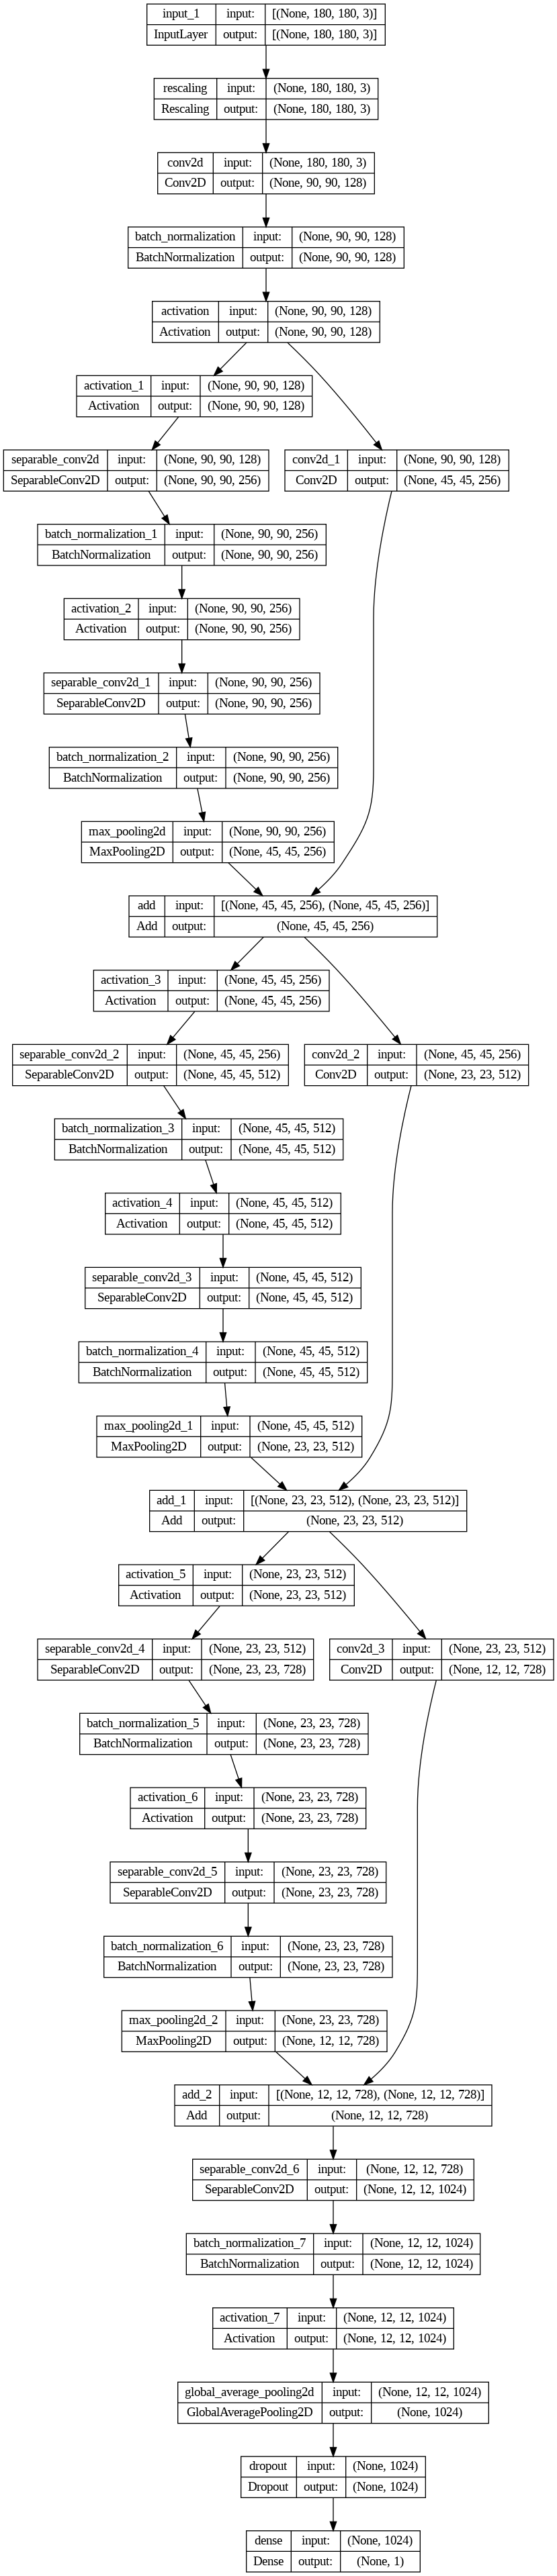

In [ ]:
def make_model(input_shape, num_classes):
    # Define the input layer with the given input shape
    inputs = keras.Input(shape=input_shape)

    # Rescale the input images to the range [0, 1]
    x = layers.Rescaling(1.0 / 255)(inputs)

    # Entry block: 2D convolution, batch normalization, and ReLU activation
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Set aside residual connection
    previous_block_activation = x

    # Loop through specified filter sizes
    for size in [256, 512, 728]:
        # First separable convolution, batch normalization, and ReLU activation
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Second separable convolution, batch normalization, and ReLU activation
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max pooling layer
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual connection and add it back to the output
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])

        # Set aside next residual connection
        previous_block_activation = x

    # Final separable convolution, batch normalization, and ReLU activation
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Global average pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # Determine output layer activation function and number of units
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # Add dropout layer and output layer with specified activation and units
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    # Return the assembled model
    return keras.Model(inputs, outputs)

# Instantiate the model with the specified input shape and number of classes
model = make_model(input_shape=image_size + (3,), num_classes=2)

# Visualize the model architecture and display the shapes of the layers
keras.utils.plot_model(model, show_shapes=True)


## Train the model

In [ ]:
# Set the number of times to iterate over the entire dataset during training
epochs = 25

# Create a list of callbacks to be used during training
callbacks = [
    # Save the model weights after each epoch
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

# Compile the model with an optimizer, loss function, and metric for evaluation
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),  # Use the Adam optimizer with a learning rate of 1e-3
    loss="binary_crossentropy",  # Use binary crossentropy loss since it's a binary classification problem
    metrics=["accuracy","AUC"],  # Use accuracy as the evaluation metric
)

# Fit the model to the training data
history = model.fit(
    train_ds,  # Use the training dataset created earlier
    epochs=epochs,  # Set the number of epochs for training
    callbacks=callbacks,  # Use the callbacks defined earlier (model checkpointing)
    validation_data=val_ds,  # Use the validation dataset created earlier for validation
)


We get to >90% validation accuracy after training for 10 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

# Model Fitting Summary

In [ ]:
# Visualize the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Calculate the AUROC for the validation set
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

In [ ]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict(val_ds)
auc_score = roc_auc_score(y_true, y_pred)
print('Validation AUROC:', auc_score)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_pred are already defined
fpr, tpr, thresholds = roc_curve(y_true, y_pred)  # Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
roc_auc = auc(fpr, tpr)  # Compute the area under the ROC curve

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [ ]:
#save the trained model

model.save('/contents/dog_cat_0424.h5')

In [ ]:
ls

 CDLA-Permissive-2.0.pdf      model.png        sample_data/
 dog_cat_0423.h5              PetImages/
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [ ]:
loaded_model = keras.models.load_model('dog_cat.h5')

1/1 [==============================] - 1s 647ms/step
This image is 92.82% cat and 7.18% dog.


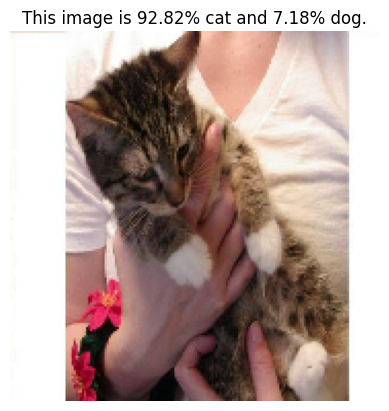

In [ ]:
# Load an image from the specified file path, resizing it to the target size
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/2333.jpg", target_size=image_size
)

# Convert the loaded image to a NumPy array
img_array = keras.preprocessing.image.img_to_array(img)

# Add an extra dimension to the array to create a batch of size 1 (required for model input)
img_array = tf.expand_dims(img_array, 0)

# Run the prediction on the preprocessed image using the loaded model
predictions = loaded_model.predict(img_array)

# Retrieve the first prediction (there is only one in the batch)
score = float(predictions[0])

# Print the prediction results as percentages for cat and dog
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

# Visualize the input image with the predicted class label
class_label = "cat" if score < 0.5 else "dog"  # Determine the predicted class label based on the score
plt.imshow(img)  # Display the input image
plt.title(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")  # Add a title with prediction percentages
plt.axis('off')  # Hide axis labels
plt.show()  # Display the image and the prediction results


1/1 [==============================] - 0s 116ms/step
This image is 0.01% cat and 99.99% dog.


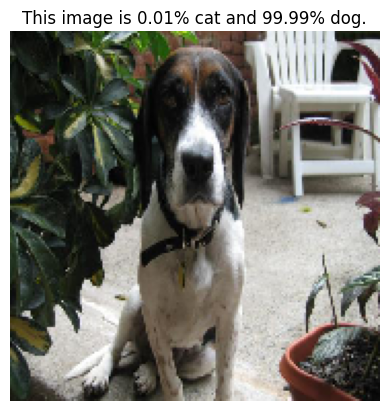

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Dog/1150.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = loaded_model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

# Visualize the input image with the predicted class label
class_label = "cat" if score < 0.5 else "dog"
plt.imshow(img)
plt.title(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
plt.axis('off')
plt.show()

1/1 [==============================] - 9s 9s/step
This image is 0.57% cat and 99.43% dog.


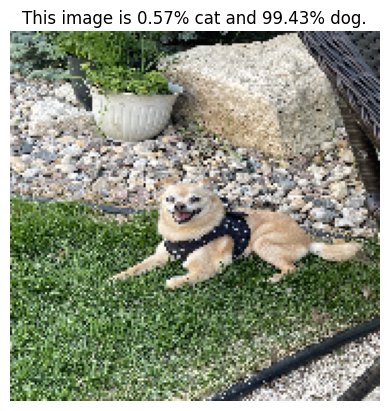

In [ ]:
img = keras.preprocessing.image.load_img(
    "taylor_dog.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = loaded_model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

# Visualize the input image with the predicted class label
class_label = "cat" if score < 0.5 else "dog"
plt.imshow(img)
plt.title(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 53ms/step
This image is 18.13% cat and 81.87% dog.


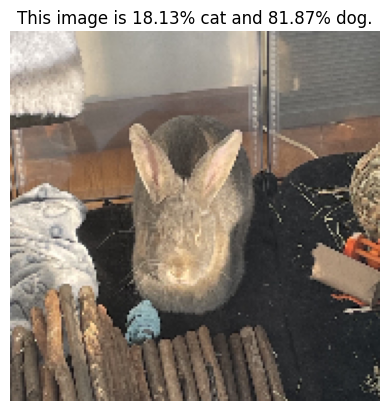

In [ ]:
img = keras.preprocessing.image.load_img(
    "rabbit_taylor.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = loaded_model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

# Visualize the input image with the predicted class label
class_label = "cat" if score < 0.5 else "dog"
plt.imshow(img)
plt.title(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 21ms/step
This image is 11.14% cat and 88.86% dog.


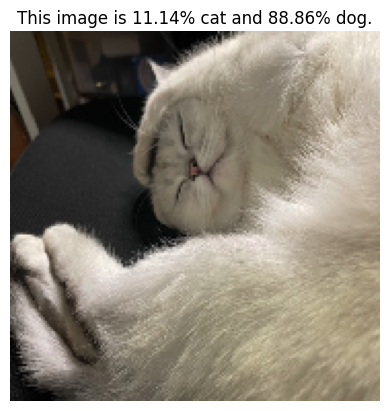

In [ ]:
img = keras.preprocessing.image.load_img(
    "qiang.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = loaded_model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

# Visualize the input image with the predicted class label
class_label = "cat" if score < 0.5 else "dog"
plt.imshow(img)
plt.title(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 22ms/step
This image is 0.03% cat and 99.97% dog.


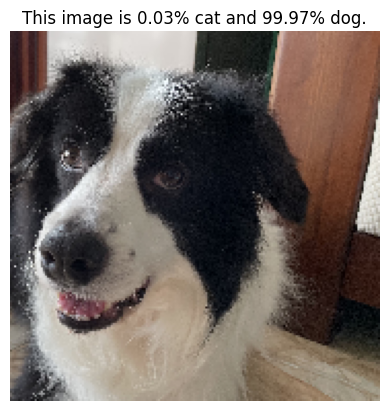

In [ ]:
img = keras.preprocessing.image.load_img(
    "liangliang.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = loaded_model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

# Visualize the input image with the predicted class label
class_label = "cat" if score < 0.5 else "dog"
plt.imshow(img)
plt.title(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 33ms/step
This image is 0.00% cat and 100.00% dog.


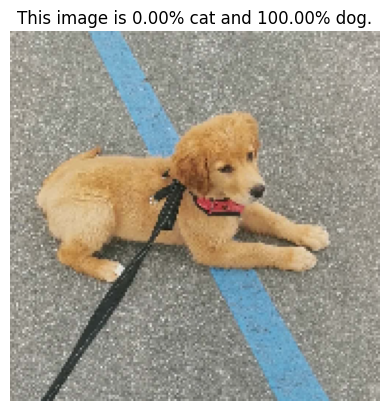

In [ ]:
img = keras.preprocessing.image.load_img(
    "chuxi.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = loaded_model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

# Visualize the input image with the predicted class label
class_label = "cat" if score < 0.5 else "dog"
plt.imshow(img)
plt.title(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
plt.axis('off')
plt.show()